<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>Introduction to Machine Learning</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Tutorial 5: Supervised learning</center>
<hr style=" border:none; height:3px;">
</h1>

__Teachers__: Myriam Tami, Gianluca Quercini, Yassine Ouali

# Introduction

In this tutorial we first use some synthetic data to understand how Support Vector Machines (SVMs) work, the effect of their hyperparameters and what the kernel trick is all about.

We also use a real dataset to train a classifier that recognizes handwritten digits.

<div class="alert alert-block alert-info">

For the most part, the Python code is already written for you. You're invited to **read the code and the comments** to learn how to practice machine learning with *Scikit-learn*. Your instructor will also explain the code.

</div>



# Setup

We import the modules that are commonly used in combination with Scikit-learn.

<div class="alert alert-block alert-warning">
In order to run this notebook, you'll need to install <b>Python 3.5 or later</b>, as well as <b>Scikit-learn 0.20 or later</b>.
</div>

In [62]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd

# Matplotlib is used to plot graphs.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Convenience function to create display a progress bar.
# Source : https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def print_progress_bar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
 
# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Experimenting with SVM

In this section we play with the hyperparameters of Support Vector Machines (SVM) and learn their effect. 
We first define the function *plot_svc_decision_boundary* that plots the decision boundary learned by a SVM.

In [63]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    ''' Plots the decision boundary of a support vector machine.
    
    Parameters
    ----------
        svn_clf : sklearn.svm.SVC
            The classifier.
        xmin: float
            The minimum value on the x-axis.
        xmax: float
            The maximum value of the x-axis.
    '''
    
    # Get the parameters learned from the training data.
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    # Get the margin and the two lines where the support vectors are.
    margin = 1/w[1]
    print(w)
    print(margin)

    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

We generate a synthetic dataset with the function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html" target="_blank">*make_classification*</a>. 

<div class="alert alert-block alert-success">

**Question 1.** In the following cell, play with the parameters *class_sep* and *flip_y* to understand their effect on the generated dataset.

</div>


[-6.523434071009125, 6.388693526431721, -6.585908560176217, 6.591239462318816]

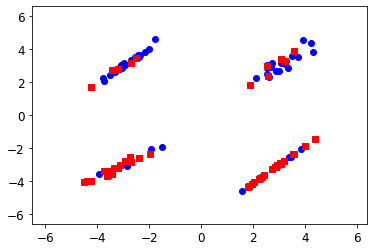

In [64]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100, 
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=3,
    flip_y=0.35, 
    random_state=42)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

<div class="alert alert-block alert-success">

**Solution.** The parameter *class_sep* determines whether the dataset is linearly separable or not.
Setting *class_sep* to lower values creates increasingly less linearly separable instances. *flip_y* determines the amount of noise in the dataset.

</div>

## Hard and soft margin

Now let's generate the following dataset. 

[-6.585908560176217, 6.591239462318816, -6.523434071009125, 6.388693526431721]

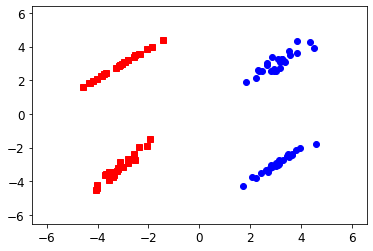

In [65]:
X, y = make_classification(
    n_samples=100, 
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=3,
    flip_y=0, 
    random_state=42)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

In the following cell, we train a linear SVM on the generated dataset. 

<div class="alert alert-block alert-success">

**Question 2.** Play with the hyperparameter $C$ of the SVM by setting the following values $10^{-3}$, $10^{-2}$, $10^{-1}$, $10^{0}$, $10^{1}$, $10^{2}$, $10^{3}$.
How does the decision boundary change?

</div>

[ 0.57179934 -0.04730319]
-21.140221871635795


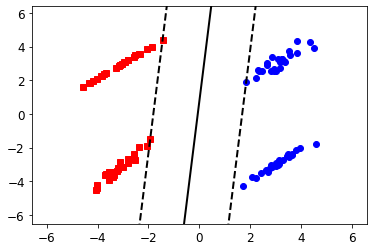

In [66]:
from sklearn.svm import SVC


svm = SVC(kernel="linear", C=10**(3), random_state=42)
svm.fit(X, y)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

plot_svc_decision_boundary(svm, X[:, 0].min() - 2, X[:, 0].max() + 2)

<div class="alert alert-block alert-success">

**Solution.** The higher the value of $C$, the narrower the margin. High values of $C$ penalize the margin violations by the training instances. On the other hand, the lower the value of $C$, the larger the margin.

</div>

Now we generate the following dataset, where some of the red instances are *outliers*, in the sense that they have values for the features that make them "look like" blue instances.

[-7.585908560176217, 7.591239462318816, -7.523434071009125, 7.388693526431721]

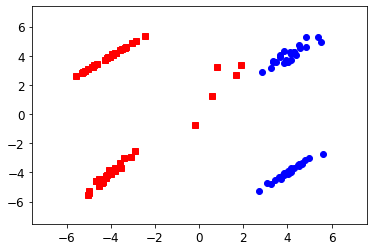

In [67]:
import random

X, y = make_classification(
    n_samples=100, 
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=4,
    flip_y=0, 
    random_state=42)

# X_outliers = [[random.uniform(-1, 2), random.uniform(-6, 6), ] for _ in range(5)]
# for i in range(len(X_outliers)):
#     X = np.vstack((X, X_outliers[i]))
#     y = np.hstack((y, [0]))
    
X_outliers = np.array([[random.uniform(-1, 2), random.uniform(-6, 6), ] for _ in range(5)])
# for i in range(len(X_outliers)):
X = np.vstack((X, X_outliers))
y = np.hstack((y, [0]*X_outliers.shape[0]))
    


plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

<div class="alert alert-block alert-success">

**Question 3.** Play again with the hyperparameter $C$ and look at how the decision boundary changes. What is the implication for the prediction model?

</div>

[ 0.3047265  -0.01443122]
-69.2942027701684


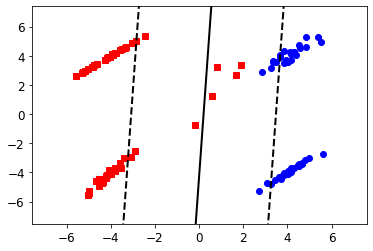

In [68]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

svm = SVC(kernel="linear", C=10**(-2), random_state=42)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
plt.axis([X[:, 0].min() - 2, X[:, 0].max() + 2, X[:, 1].min() - 2, X[:, 1].max() + 2])

svm.fit(X, y)
plot_svc_decision_boundary(svm, X[:, 0].min() - 2, X[:, 0].max() + 2)


<div class="alert alert-block alert-success">

**Solution.** High values of $C$ (cf. $10^3$) force the decision boundary to fit the training data perfectly. This means that the prediction algorithm learns a model from the outliers too, which might be a problem when applying the model itself to unseen instances (some actual blue instances might be mistaken for red instances).
In contrast, low values of $C$ force the decision boundary to have a larger margin; with $10^{-3}$ some of the red training instances are misclassified; but since the prediction model doesn't learn the noise, it might generalize better to unseen instances.

</div>

<div class="alert alert-block alert-success">

**Question 4.** Based on the experiences of the previous question, what would you do on the values of $C$ if you realized that your prediction model is overfitting? What if your model is underfitting?

</div>

<div class="alert alert-block alert-success">

**Solution.** If the model overfits, then it means that the value of $C$ is too high and should be decreased. Conversely, if the model is underfitting, then the value of $C$ is too low and should be increased.

</div>

## Nonlinear SVM classification

SVMs are defined for linearly separable classification problems; however, many real datasets are not linearly separable. One approach to handling these cases is to add more features. One example is to add polynomial features.

The following cell generates a dataset where each instance is described by only one feature $x_1$. Clearly, the instances are not linearly separable.

[-4.5, 4.5, -0.2, 0.2]

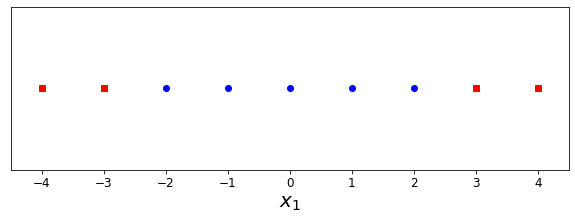

In [69]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))
plt.plot(X1D[:, 0][y==0], np.zeros(4), "rs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "bo")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])


<div class="alert alert-block alert-success">

**Question 5.** Propose a transformation of the given dataset to a 2-dimensional space by defining a new feature $x_2$ obtained as a polynomial of $x_1$. Implement the transformation and train a linear SVM on the transformed dataset.

</div>

<div class="alert alert-block alert-success">

**Solution.** One possible transformation consists in adding a feature  $x_2 = (x_1)^2$.
The code is provided below.
</div>

[-6.9388939e-17 -4.0010026e-01]
-2.4993735347246244


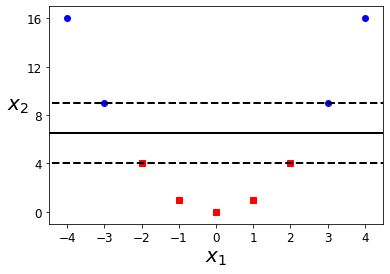

In [70]:
# Solution

X2D = np.c_[X1D, X1D**2]

plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bo")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "rs")

plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.axis([-4.5, 4.5, -1, 17])

svm = SVC(kernel="linear", C=10**(0), random_state=42)
svm.fit(X2D, y)
plot_svc_decision_boundary(svm, X2D[:, 0].min() - 2, X2D[:, 0].max() + 2)

Making up polynomial features is easy when we have a toy dataset such as the one in the previous question. Consider the following dataset. It is generated by using the Scikit-learn function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html" target="_blank">make_moons</a>. 

Although the resulting dataset is still very simple, it would be more difficult than before to create new features especially because that would require the visualization of  the transformed dataset in three or more dimensions.

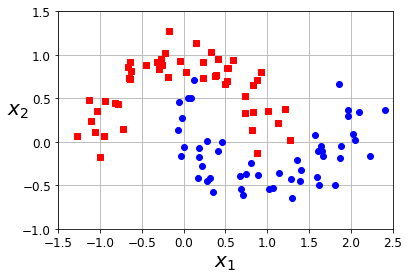

In [71]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Scikit-learn comes to our rescue by providing the class <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html" target="_blank">*PolynomialFeatures*</a> that allows for the creation of new polynomial features with no intervention from us. The only thing that we need to do is to specify the degree of the polynomial.


<div class="alert alert-block alert-success">

**Question 6.** In the code below, play with the degree of the polynomial. What happens if you increase its value? What happens if you decrease it?

</div>

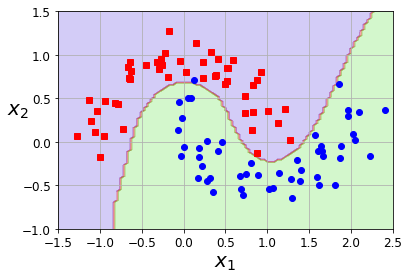

In [80]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
#     plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures


polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=4)),
        ("svm_clf", SVC(C=10, kernel="linear"))
    ])

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

<div class="alert alert-block alert-success">

**Solution.** The degree of the polynomial acts as a regularization parameter. Higher values will force the decision boundary to fit the training data well (which might lead to overfitting); lower values will result in a decision boundary that adapts less well to the training instances (which might lead to underfitting). 
Note that when the degree of the polynomial is 1, we fall back to training a linear SVM.

</div>

<div class="alert alert-block alert-success">

**Question 7.** Would you consider the solution of adding new features to the dataset acceptable? What is the main problem here? 

</div>

<div class="alert alert-block alert-success">

**Solution.** In order to limit the number of new features, we should keep the degree of the polynomial as low as possible. However, a low polynomial degree might not be sufficient for complex datasets; increasing the degree would necessarily result in a high number of new features. This is where the *kernel trick* comes into play.

</div>

### The kernel trick

The **kernel trick** allows us to obtain the exact same result we were trying to get by adding more features without the need of adding new features. 

Suppose that we have a non-linearly separable dataset where each instance $\mathbf{x}$ is defined by two features $(x_1, x_2)$.  Suppose that we have a function $\phi$ that transforms the dataset into one in three dimensions, where it is linearly separable. The function $\phi$ is defined as follows:

$$
\begin{align}
    \phi(\mathbf{x}) &= 
          \begin{pmatrix}
           x_1^2 \\           
           \sqrt{2} x_1 x_2 \\
           x_2^2
          \end{pmatrix}
  \end{align}
$$

Consider now two instances $\mathbf{a} = (a_1, a_2)$ and $\mathbf{b} = (b_1, b_2)$ and what happens when we apply the dot product of the transformed vectors:

$$
\begin{align}
    \phi(\mathbf{a})^T \phi(\mathbf{b})  &= 
          \begin{pmatrix}
           a_1^2 \\           
           \sqrt{2} a_1 a_2 \\
           a_2^2
          \end{pmatrix}^T
          \times
          \begin{pmatrix}
           b_1^2 \\           
           \sqrt{2} b_1 b_2 \\
           b_2^2
          \end{pmatrix}
          = a_1^2 b_1^2 + 2 a_1 b_1 a_2 b_2 + a_2^2 b_2^2 = (a_1 b_1 + a_2 b_2)^2 = (\mathbf{a}^T \mathbf{b})^2
  \end{align}
$$

In practice, the dot product of the transformed vectors can be computed by using the values of the features in the original space! Therefore, there is no need to make any transformation at all! This is extremely important, because when solving the constrained optimization problem of the SVM, we can plug the dot product $\phi(\mathbf{a})^T \phi(\mathbf{b})$ in the dual formulation, which results in training the SVM in a higher dimensional space, without computing the transformation explicitly. The transformation $\phi$ is a **kernel function**, one that can compute the dot product $\phi(\mathbf{a})^T \phi(\mathbf{b})$ based only on the original vectors. 

A common kernel that we're going to use in the following cell is the **polynomial kernel**, defined as follows:

$$
K(\mathbf{a}, \mathbf{b}) = (\gamma \mathbf{a}^T \mathbf{b} + r)^d
$$

This kernel is defined by three parameters:

* $\gamma$: is a scaling factor. Low values of $\gamma$ will erase the effect of a large degree. This parameter is usually not considered (scikit-learn sets its value to 1/num_features).

* $d$: is the degree of the polynomial. In Scikit-learn, this parameter is called $degree$.

* $r$: is a free parameter trading off the influence of higher-order versus lower-order terms in the polynomial. Scikit-learn sets its default value to 0. Some references set its value to 1. In Scikit-learn this parameter is called $coef0$.

<div class="alert alert-block alert-success">

**Question 8.** Looking at the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">documentation of SVC</a> in Scikit-Learn, write the code the trains a SVM with polynomial kernel for the training set $(X, y)$. Play with the parameters $degree$ and $coef0$.

</div>

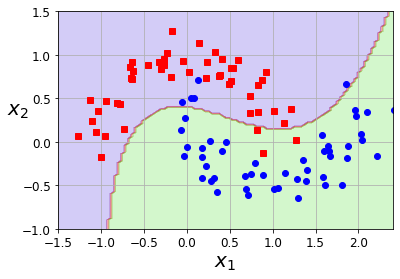

In [93]:
#Solution

poly_kernel_svm_clf = Pipeline([
        ("svm_clf", SVC(kernel="poly", degree=3, gamma='auto', coef0=1, C=0.9))
    ])

poly_kernel_svm_clf.fit(X, y)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])



<div class="alert alert-block alert-success">

**Solution.** Let's set $coef0 = 1$; increasing the polynomial leads to a decision boundary that fits increasingly well to the training data. The values of $coef0$ can be used to decrease the effect of the higher-order terms in the polynomial. For instance, setting $coef0=1000$ and $degree$=5 leads to a decision boundary that is not that far from the one obtained with $degree=3$ and $coef0=1$. In general, it would be a good idea to set $coef0=1$ and let the degree vary. In essence, the degree is the only hyperparameter to consider here.

</div>

Adding polynomial features is not the only way to transform a non-linearly separable dataset into a linearly separable one. Another technique consists in adding features computed using a *similarity function*, which measures how much each instance resembles a particular reference point, also termed a *landmark* $l$.

Let's consider again the dataset with only one feature.

[-4.5, 4.5, -0.2, 0.2]

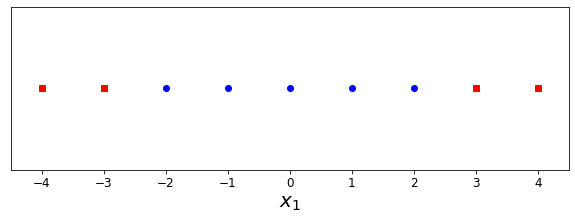

In [94]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))
plt.plot(X1D[:, 0][y==0], np.zeros(4), "rs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "bo")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

Suppose that we want to transform the dataset so as it is described by two features. We define two landmarks; the first $\mathbf{l_1}$ is defined at $x_1 = -2$ and the other $\mathbf{l_2}$ is defined at $x_1 = 1$. 

each instance will be described by two new features $x_2$ and $x_3$, where the value of $x_2$ is the similarity of the instance to the first landmark $\mathbf{l_1}$ and the value of $x_3$ is the similarity of the instance to the second landmark $\mathbf{l_2}$.

More precisely, let's define the following similarity measure, called the Gaussian **Radial Basis Function** (RBF):

$$\phi_\gamma(\mathbf{x}, \mathbf{l}) = exp(-\gamma || \mathbf{x} - \mathbf{l} ||^2)$$

Let $\gamma = 0.3$; if we take the instance at $x_1=-1$, its distance from the first landmark is 1, while its distance from the second landmark is 2. Therefore, its new features will be $exp(-0.3 \times 1^2) \approx 0.74$ and 
$exp(-0.3 \times 2^2) \approx 0.30$. This can be iterated for every instance, which will give the new dataset that is now linearly separable.

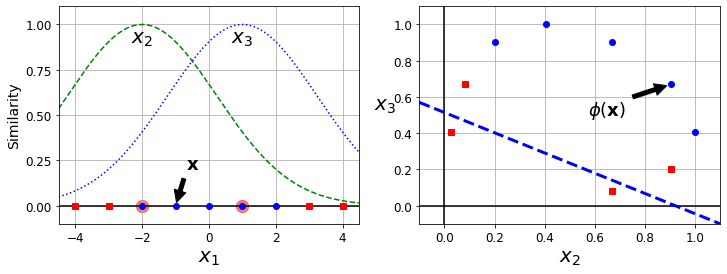

In [103]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.1

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "rs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "bo")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "rs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "bo")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "b--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

<div class="alert alert-block alert-success">

**Question 9.** Rerun the previous cell by using different values for $\gamma$. What happens when you decrease the value of $\gamma$? What happens when you increase it?

</div>

<div class="alert alert-block alert-success">

**Solution.** Decreasing the value of $\gamma$ results in a "wider bell" of the Gaussian curve. This means that the value of the similarity between an instance and a landmark will be high even if the instance is relatively far from the landmark. In other words, the region of influence of a landmark is larger.

Conversely, if we decrease the value of $\gamma$ we obtain a "narrower bell"; this means that the value of the similarity between an instance and a landmark will be low even if the instance is relatively close to the landmark. In other words, the region of influence of a landmark is smaller.

</div>

As in the case of the polynomial features, the kernel trick comes to our rescue here too.
In fact, we can use the **Gaussian RBF Kernel** to obtain the same result without transforming the dataset.
The RBF kernel is defined as follows:

$$K(\mathbf{x}, \mathbf{y}) = exp(-\gamma || \mathbf{x} - \mathbf{y} ||^2)$$

<div class="alert alert-block alert-success">

**Question 10.** Run the following cell that trains a SVM with RBF kernel with different values of $\gamma$ and $C$. Comment on the effect of both parameters on the decision boundary.

</div>

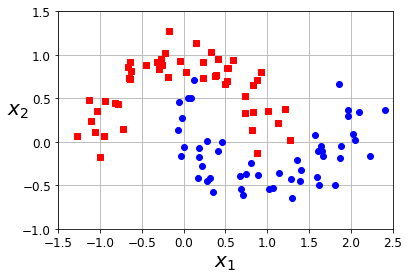

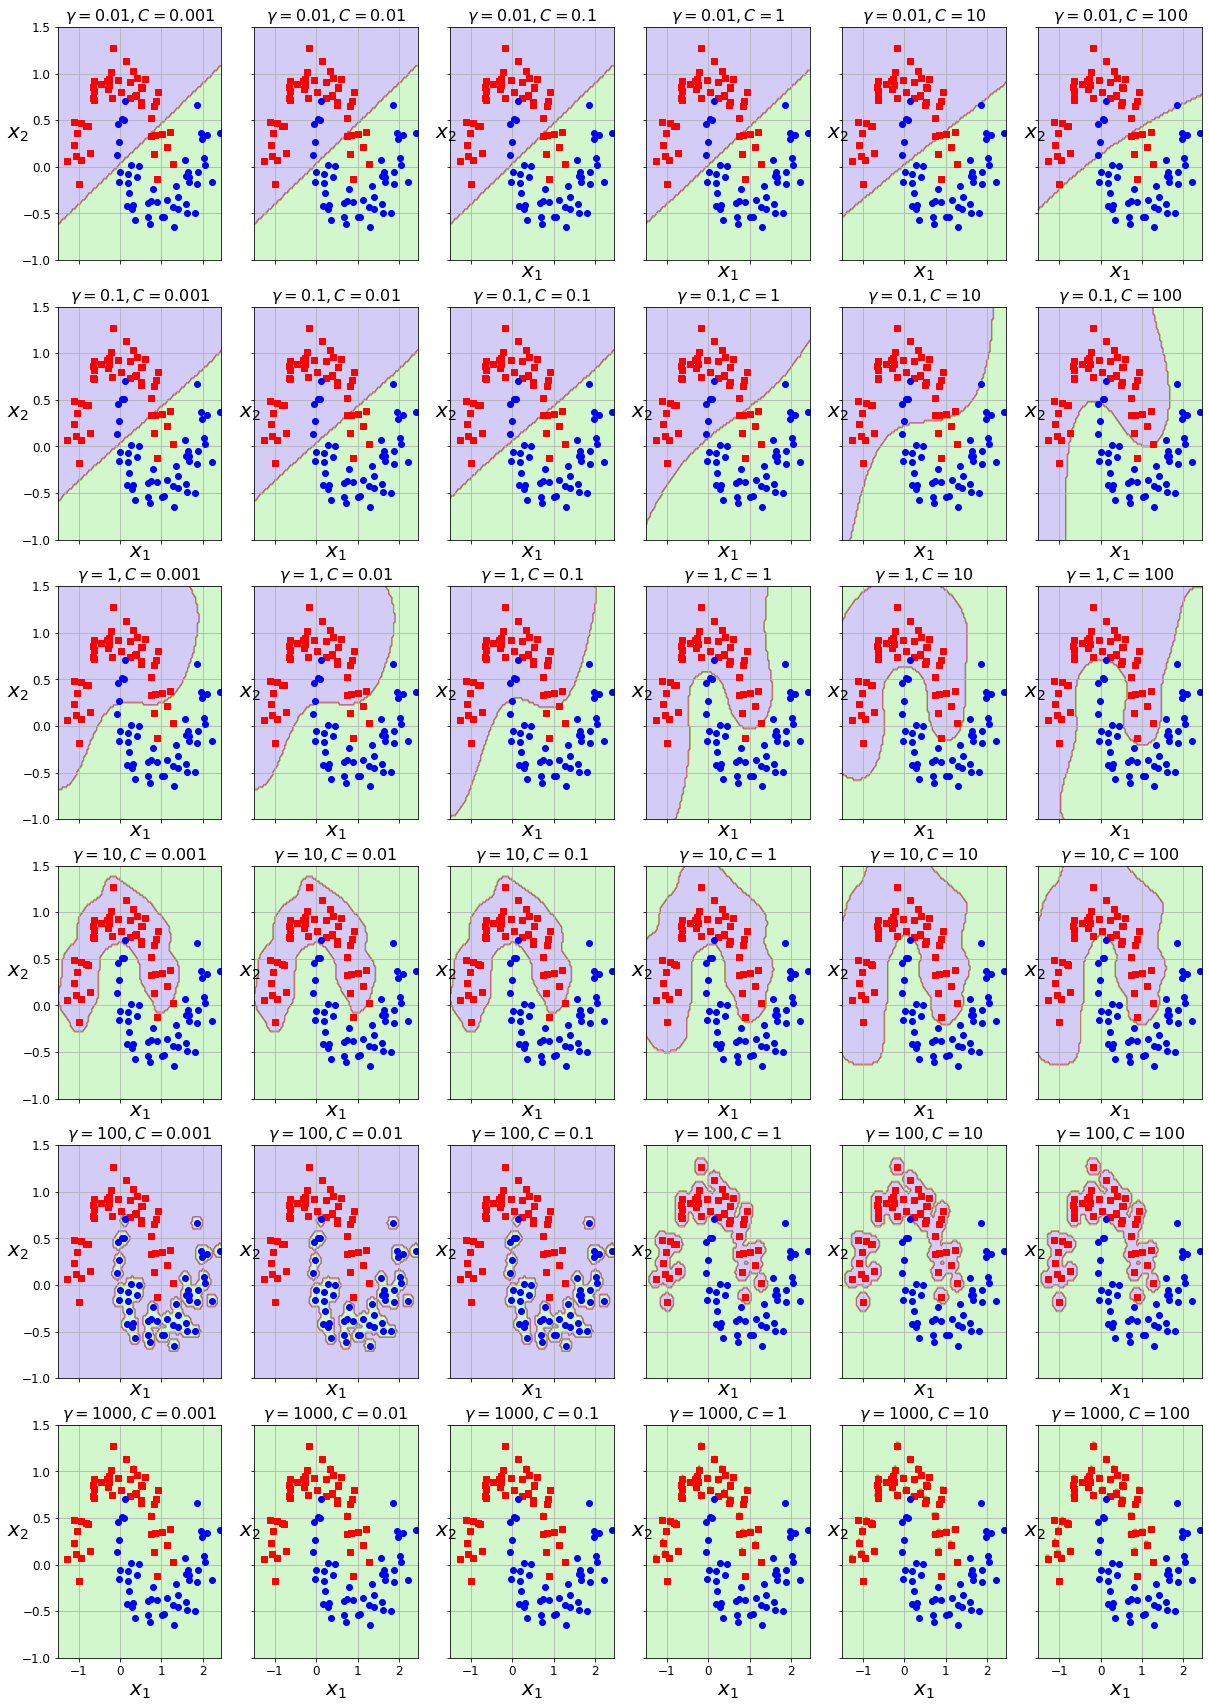

In [104]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

hyperparams = [(10**i, 10**j) for i in range(-2, 4) for j in range(-3, 3)]


svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20.5, 30), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 6, i % 6])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")



<div class="alert alert-block alert-success">

**Solution.** Low values of $\gamma$ (i.e., 0.01) lead to a decision boundary that resembles the one produced by a linear model, even for high values of $C$. A small value of $\gamma$ means that the region of influence of the support vectors is too large; even instances that are far from the support vectors are considered as similar to them.

Intermediate values of $\gamma$ (i.e., 0.1, 1 and 10) lead to models with decision boundaries that are likely to generalize better; the value of $C$ acts as a regularization parameter, with higher values producing decision boundaries that fit the training instances better.


For large values of $\gamma$ (i.e., 100 and 1000), the region of influence of the support vectors is too narrow (they end up including only themselves). No value of $C$ is able to change this behaviour. In this case, we have overfitting, no matter the value of $C$.
</div>

# Experimenting with real data

## Dataset MNIST and SVM

We're going to consider the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

First of all, let's download the dataset and split it into a training and test set. The training set is composed of the first 60000 instances.

In [106]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"][:100]
y = mnist["target"][:100].astype(np.uint8)

X_train = X[:60]
y_train = y[:60]
X_test = X[60:]
y_test = y[60:]



<div class="alert alert-block alert-info">

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first. However, the dataset is already shuffled, so we do not need to do it.

</div>



By running the following cell, we get the number of training instances, the number of features  and the classes.

In [107]:
print("Number of training instances {}".format(np.ma.size(X_train, axis=0)))
print("Number of test instances {}".format(np.ma.size(X_test, axis=0)))
print("Number of features {}".format(np.ma.size(X_train, axis=1)))
print("Classes {}".format(np.unique(y_train)))

Number of training instances 60
Number of test instances 40
Number of features 784
Classes [0 1 2 3 4 5 6 7 8 9]


As you can see, there are 9 classes. It is not a binary classification problem.

<div class="alert alert-block alert-success">

**Question 11.** How can we train a SVM on a multi-class classification problem?

</div>

<div class="alert alert-block alert-success">

**Solution.** There are two possibilities: One-vs-One or One-vs-All. 

The first option considers each binary pair of classes and trains a classifier on a subset of data belonging to those classes. In our case, 9*(9-1)/2 = 36 classifiers are trained. While classifying an instance, each classifier predicts one class; the class which is predicted the most is the one that is assigned to the instance.

The second option trains one classifier per class. For each classifier, the class is trained against all the other classes. In our case, we train 9 classifiers. When classifying an instance, its distance from each decision boundary is computed; the instance is assigned to the class determined by the decision boundary that is the farthest from the instance.

</div>

<div class="alert alert-block alert-info">
So far, we have only used the class SVC from the Scikit-learn. However, in order to train a linear classifier, we can also use the class <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html" target="_blank">LinearSVC</a>. 

Its implementation is based on the library *liblinear* instead of *libsvc* and is optimized for the linear case (it does not support the kernel trick). Its computational time scales linearly with the number of instances in the dataset. 

</div>

Let's try a linear SVM to begin with. LinearSVC implements the strategy One-vs-All automatically.

<div class="alert alert-block alert-warning">

The following might take a little while.

</div>

In [108]:
from sklearn.svm import LinearSVC
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

Let's evaluate the f1-score on the training set itself.

In [110]:
from sklearn.metrics import f1_score

y_pred = lin_clf.predict(X_train)
f1_score(y_train, y_pred, average='micro')

1.0

A f1-score of 0.895 is far from optimal on this dataset.


<div class="alert alert-block alert-success">

**Question 12.** What can you do to improve the results? Is there anything that we plainly ignored up until now when training a SVM?

</div>

<div class="alert alert-block alert-success">

**Solution.** We never considered the standardization of the instances. SVMs are very sensitive on the scale of the instances. It is a step that we should never forget!

</div>

In [112]:
#Solution
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

Train again a linear SVM.

<div class="alert alert-block alert-warning">

The following might take a little while.

</div>

In [113]:
#Solution
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

We now try again to predict the training instances:

In [114]:
#Solution
y_pred = lin_clf.predict(X_train_scaled)
f1_score(y_train, y_pred, average='micro')

1.0

Let's use a RBF kernel. Use only 10000 training instances in order to make the training phase faster.

In [115]:
#Solution
svm_clf = SVC(gamma="scale")
# svm_clf.fit(X_train_scaled[:10000], y_train[:10000])
svm_clf.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

We test again on the training instances.

In [116]:
#Solution
y_pred = svm_clf.predict(X_train_scaled)
f1_score(y_train, y_pred, average='micro')

0.9500000000000001

Discuss the result that you obtained.

Now, we use only 1000 instances in order to run cross-validation and try to find the best hyperparameters $C$ and $\gamma$.

In [122]:
reciprocal(0.001, 0.1)

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=1, verbose=2, cv=3)
# rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])
rnd_search_cv.fit(X_train_scaled, y_train)


rnd_search_cv.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] C=1.4224889219312178, gamma=0.003006063883165422 ................
[CV] . C=1.4224889219312178, gamma=0.003006063883165422, total=   0.0s
[CV] C=1.4224889219312178, gamma=0.003006063883165422 ................
[CV] . C=1.4224889219312178, gamma=0.003006063883165422, total=   0.0s
[CV] C=1.4224889219312178, gamma=0.003006063883165422 ................
[CV] . C=1.4224889219312178, gamma=0.003006063883165422, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/lastaw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.48333333333333334

TypeError: _passthrough_scorer() missing 1 required positional argument: 'estimator'

The result might seem a bit deceiving, given that before we had more than a f1 score of 0.945. However, we trained on only 1/60 of the training set. Let's train the best classifier that we found with cross-validation on 10000 instances.

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled[:10000], y_train[:10000])

Let's use the model to make predictions on the test set.

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
f1_score(y_test, y_pred, average='micro')